In [41]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [42]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [43]:
!wget --no-check-certificate \
    https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-07-14 20:25:22--  https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11979363 (11M) [application/x-httpd-php]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  11.42M  15.5MB/s    in 0.7s    

2021-07-14 20:25:23 (15.5 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [11979363/11979363]



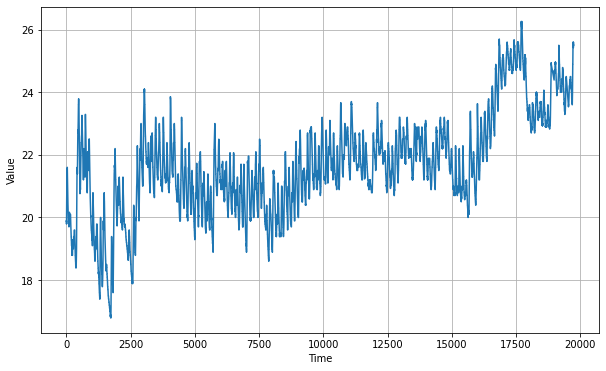

In [44]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[3]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [45]:
import numpy as np
import pandas as pd

In [46]:
data_train = pd.read_csv('/tmp/daily-min-temperatures.csv')
data_train.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [47]:
batas_mae = (series.max() - series.min())*0.1
print(batas_mae)

0.9470000000000003


In [48]:
len(time)

19735

In [49]:
split_time = 0.8 * (len(time))
split_time = int(split_time)

In [50]:
split_time

15788

In [51]:

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [52]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [53]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [54]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < (batas_mae - 0.4)):
      print("\n Melawati batas mae, training dihentikan!")
      self.model.stop_training = True

callbacks = myCallback()


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, verbose =1, callbacks=[lr_schedule,callbacks])



<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(15788,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
62/62 [==============================] - 6s 37ms/step - loss: 36.6613 - mae: 37.1582
Epoch 2/100
62/62 [==============================] - 3s 39ms/step - loss: 20.9784 - mae: 21.4772
Epoch 3/100
62/62 [==============================] - 3s 39ms/step - loss: 7.7196 - mae: 8.2115
Epoch 4/100
62/62 [==============================] - 3s 39ms/step - loss: 3.0660 - mae: 3.5109
Epoch 5/100
62/62 [==============================] - 3s 39ms/step - loss: 2.7013 - mae: 3.1425
Epoch 6/100
62/62 [==============================] - 3s 39ms/step - loss: 2.3970 - mae: 2.8343
Epoch 7/100
62/62 [==============================] - 3s 40ms/step - loss: 2.1230 - mae: 2.5506
Epoch 8/100
62/62 [==============================] - 2s 38ms/step - loss: 1.9056 - mae: 2.3207
Epoch 9/100
62/62 [==============================] - 3s 39ms/step - loss: 1.7589 - mae: 2.1690
Epoch 10/100
62/62 [==============================] - 3s 40ms/step - loss: 1.6474 - mae: 2.0562
Epoch 11/100
62/62 [=========================

(1e-08, 0.0001, 0.0, 60.0)

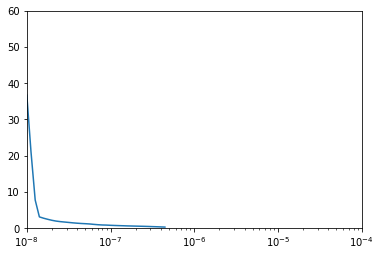

In [55]:

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [64]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

TypeError: ignored

In [56]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

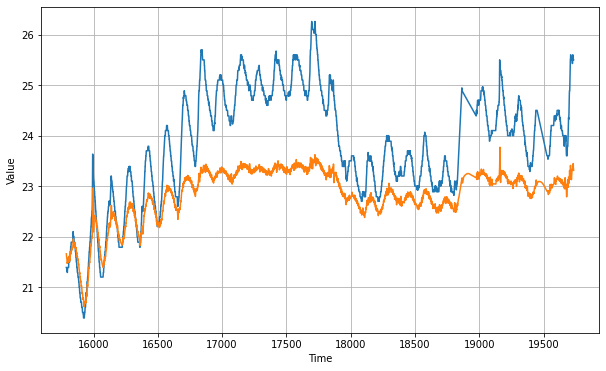

In [57]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [58]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.0019387

In [59]:
print(rnn_forecast)

[21.659115 21.630161 21.606424 ... 23.366117 23.35664  23.312431]


In [83]:
import matplotlib.pyplot as plt
loss = history.history['loss']





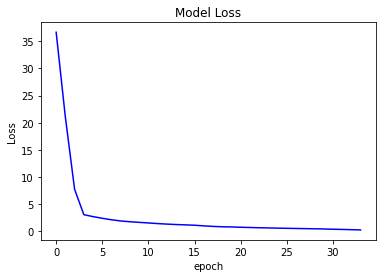

In [85]:
plt.plot(loss, color='blue')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')

plt.show()

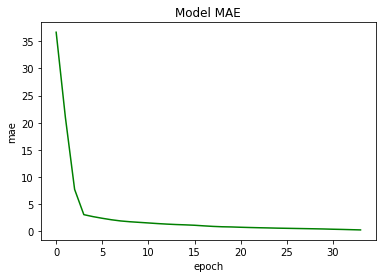

In [86]:
plt.plot(loss, color='green')

plt.title('Model MAE')
plt.ylabel('mae')
plt.xlabel('epoch')

plt.show()